<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/optical_flow/fan_track_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fan track Simple**

Simple way to track fan baldes and estimate their angular velocity

In [1]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/itberrios/CV_projects/main/fan.MOV

--2023-10-08 13:56:33--  https://raw.githubusercontent.com/itberrios/CV_projects/main/fan.MOV
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2065412 (2.0M) [video/quicktime]
Saving to: ‘fan.MOV’

fan.MOV             100%[===================>]   1.97M  --.-KB/s    in 0.06s   

2023-10-08 13:56:33 (32.8 MB/s) - ‘fan.MOV’ saved [2065412/2065412]



In [3]:
video = cv2.VideoCapture("fan.MOV")

if (video.isOpened() == False):
    print("Error opening video file")

# get frame rate
fps = video.get(cv2.CAP_PROP_FPS)

frames = []
while(video.isOpened()):

    # read each video frame
    ret, frame = video.read()

    if ret == True:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Break if nothing is returned
    else:
        break

# clean up
video.release()
cv2.destroyAllWindows()
del video

The main idea is to determine if a fan blade passes a certain boundary. We can use the frequency of this fan blade to determine the angular velocity of the fan. We will use dense Optical flow to determine when a fan blade passes the boundary

#### **Assumptions**
- Fan dimensions are known
- Camera is stationary

Another way would be to use sparse optical flow and determine the overall rigid body transformations between frames.

We could also exploit the stationarity of the fan and use the assumption that most background objects do not move and compute the rigid body transformation between frames, we could use that along with the known fan dimensions to directly estimate the fan's angular vecloity.

In [104]:
idx = 6

frame1 = frames[idx]
frame2 = frames[idx + 1]

In [105]:
boundary_line = np.array([275, 0, 275, 50])
x1,y1,x2,y2 = boundary_line

In [106]:
bframe = cv2.line(frame1.copy(), (x1,y1), (x2,y2), (0,255,0), 3)

# bframe = cv2.rectangle(frame1.copy(), (250, 0), (285, 100), (0,255,0), 3)

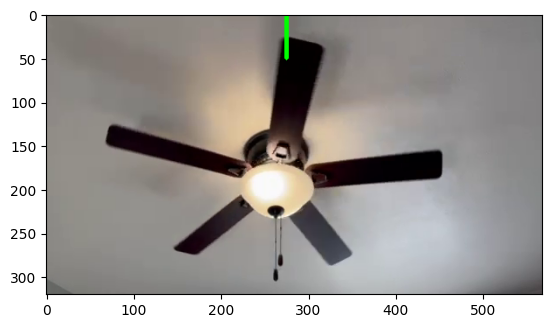

In [107]:
plt.imshow(bframe)

### Compurte Optical Flow

In [87]:
def compute_flow(frame1, frame2):
    # convert to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

    # blurr image
    gray1 = cv2.GaussianBlur(gray1, dst=None, ksize=(3,3), sigmaX=5)
    gray2 = cv2.GaussianBlur(gray2, dst=None, ksize=(3,3), sigmaX=5)

    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.5,
                                        levels=3,
                                        winsize=5,
                                        iterations=3,
                                        poly_n=10,
                                        poly_sigma=1.2,
                                        flags=0)

    return flow


def viz_flow(flow):
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3)).astype(np.uint8)
    hsv[..., 1] = 255
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb

In [88]:
flow = compute_flow(frame1, frame2)

# leftward motion
left_motion = (flow[:, :, 0] < -1).astype(np.uint8)*255
# right_motion = flow[:, :, 0] > 1

kernel = np.ones((1, 11))

opening = cv2.morphologyEx(left_motion, cv2.MORPH_OPEN, kernel)

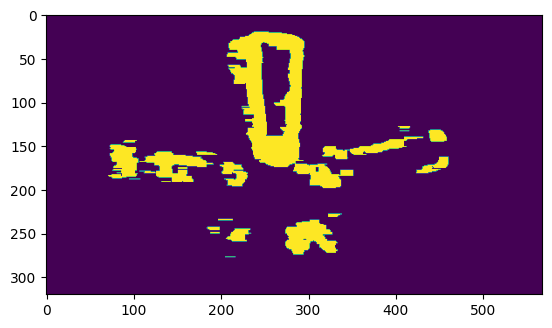

In [89]:
plt.imshow(opening)

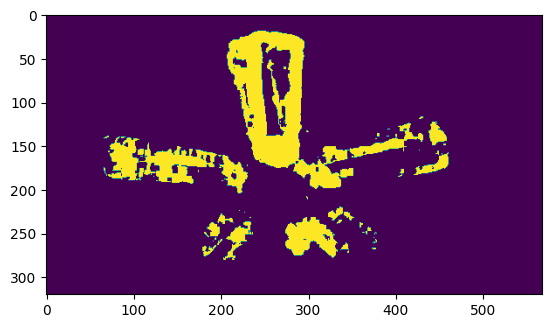

In [90]:
plt.imshow(left_motion)

Determine if moving fan blade has crossed the line (we can clean this up later). All we need to do is consider all vertical pixels less than 50 at horizontal position 275 and add a +/-5 padding to help out. If the detected fan motion has encroached on this, then we can label this a "blade detection"!